<h1>Analysis of Senator Stock Trading</h1>

Patrick Cao

<h2>Introduction</h2>

Insider trading, or trading financial assets using information that is not open to the public, is punishable by law in the United States. It is a serious violation -- a maximum penalty of 20 years in prison, and up to $20 million in fines. The Securities and Exchange Commission (SEC) is responsible for identifying and conducting investigations regarding insider trading.

With that being said, U.S. senators (and other congresspeople) often have access to information about upcoming policies or laws before the general public, yet are still allowed to trade stocks. More recently, a few senators have been investigated by the SEC for insider trading using knowledge given to them about the COVID-19 pandemic. 

This tutorial aims to identify potential insider trading, or suspicious trades, by U.S. senators. We will be using data from https://senatestockwatcher.com/, which itself compiles data from https://efdsearch.senate.gov/. Senate stock watcher aggregates financial disclosures from all senators into one nice dataset.

Let's first start by downloading the dataset. While Senate Stock Watcher provides an API for up to date datasets, we can just download a csv file as well. Download the "All Transactions" csv file from https://senatestockwatcher.com/api.html.

Let's load that into a pandas dataframe.

In [150]:
import pandas as pd
import numpy as np
import datetime

df = pd.read_csv('all_transactions.csv')
df.head()

,transaction_date,owner,ticker,asset_description,asset_type,type,amount,comment,senator,ptr_link
0,10/13/2020,Joint,--,"XEROX CORP <div class=""text-muted""><em>Rate/Co...",Corporate Bond,Sale (Full),"$1,001 - $15,000",Called bond,Sheldon Whitehouse,https://efdsearch.senate.gov/search/view/ptr/d...
1,10/09/2020,Self,FTV,Fortive Corporation (Exchanged) <br> Vontier C...,Stock,Exchange,"$1,001 - $15,000",--,Sheldon Whitehouse,https://efdsearch.senate.gov/search/view/ptr/d...
2,04/05/2019,Spouse,NVS,Novartis AG,Stock,Sale (Full),"$1,001 - $15,000",--,William Cassidy,https://efdsearch.senate.gov/search/view/ptr/7...
3,10/16/2020,Child,NVDA,NVIDIA Corporation,Stock,Purchase,"$1,001 - $15,000",Underlying asset of Fidelity Brokerage - Depen...,Ron L Wyden,https://efdsearch.senate.gov/search/view/ptr/4...
4,10/16/2020,Child,WDAY,"Workday, Inc.",Stock,Purchase,"$1,001 - $15,000",Underlying asset of Fidelity Brokerage - Depen...,Ron L Wyden,https://efdsearch.senate.gov/search/view/ptr/4...


Let's clean this up a little by limiting and purchases and sales only.

In [151]:
# Turn transaction_date from string into datetime
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

# Remove (Full) and (Partial) after Sale type
df['type'] = df['type'].apply(lambda x: x.split()[0])

# Limit to only purchases and sales
df = df[(df['type'] == 'Purchase') | (df['type'] == 'Sale')]
df.head()

,transaction_date,owner,ticker,asset_description,asset_type,type,amount,comment,senator,ptr_link
0,2020-10-13,Joint,--,"XEROX CORP <div class=""text-muted""><em>Rate/Co...",Corporate Bond,Sale,"$1,001 - $15,000",Called bond,Sheldon Whitehouse,https://efdsearch.senate.gov/search/view/ptr/d...
2,2019-04-05,Spouse,NVS,Novartis AG,Stock,Sale,"$1,001 - $15,000",--,William Cassidy,https://efdsearch.senate.gov/search/view/ptr/7...
3,2020-10-16,Child,NVDA,NVIDIA Corporation,Stock,Purchase,"$1,001 - $15,000",Underlying asset of Fidelity Brokerage - Depen...,Ron L Wyden,https://efdsearch.senate.gov/search/view/ptr/4...
4,2020-10-16,Child,WDAY,"Workday, Inc.",Stock,Purchase,"$1,001 - $15,000",Underlying asset of Fidelity Brokerage - Depen...,Ron L Wyden,https://efdsearch.senate.gov/search/view/ptr/4...
5,2020-10-16,Child,NVDA,NVIDIA Corporation,Stock,Purchase,"$1,001 - $15,000",Underlying asset of Fidelity Brokerage - Depen...,Ron L Wyden,https://efdsearch.senate.gov/search/view/ptr/4...


We got our senator stock trading data, but now we need actual historical market data to visualize these trades. Let's use yfinance, a python Yahoo! Finance library, to get historical market data on SPY, an ETF tracking the S&P500.

In [152]:
import yfinance as yf

spy = yf.Ticker('SPY')
spy_hist = spy.history(period='max')
spy_hist.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-11-30,362.829987,363.119995,359.170013,362.059998,83872700,0.0,0
2020-12-01,365.570007,367.679993,364.929993,366.019989,74505000,0.0,0
2020-12-02,364.820007,366.959991,364.200012,366.790009,45927000,0.0,0
2020-12-03,366.679993,368.190002,365.500000,366.690002,62663700,0.0,0
2020-12-04,367.320007,369.850006,367.220001,369.779999,50691643,0.0,0


Neat! Now we can start putting these two things together.

<h2>Exploratory Data Analysis</h2>

Let's first aggregate all the senator trading data together, and find the overall trading performance of the senate. We should somehow plot overall senator trading performance against the S&P500.

<h3>Senator Data</h3>

It's a little tough to track performance exactly. The size of each trade isn't an exact number -- it's a range. Let's check out what kinds of values we're working with here.

In [153]:
df['amount'].unique()

array(['$1,001 - $15,000', '$15,001 - $50,000', '$1,000,001 - $5,000,000',
       '$250,001 - $500,000', '$500,001 - $1,000,000',
       '$50,001 - $100,000', '$100,001 - $250,000',
       '$5,000,001 - $25,000,000', 'Over $50,000,000',
       '$25,000,001 - $50,000,000'], dtype=object)

Yikes. The data doesn't have the exact value of securities traded, the best thing we can probably do is get the lower bound, upper bound, and middle value of each trade, and use that to estimate the value of each trade.

In [154]:
# Returns a tuple of [lower bound, middle, upper bound] for the given category
def getBounds(amount):
    
    # This amount shows up once in the entire dataset. Let's just assume the trade is $50m for now. It won't affect our analysis too much.
    if amount == 'Over $50,000,000':
        return (5e7, 5e7, 5e7)
    
    split = amount.split(' - ')
    lower = int(split[0][1:].replace(',', ''))
    upper = int(split[1][1:].replace(',', ''))
    mid = lower + ((upper - lower) / 2)

    return [lower, mid, upper]

bounds = pd.Series(df['amount'].apply(getBounds))

df['lower_amt'] = bounds.apply(lambda x: x[0])
df['mid_amt'] = bounds.apply(lambda x: x[1])
df['upper_amt'] = bounds.apply(lambda x: x[2])

df

,transaction_date,owner,ticker,asset_description,asset_type,type,amount,comment,senator,ptr_link,lower_amt,mid_amt,upper_amt
0,2020-10-13,Joint,--,"XEROX CORP <div class=""text-muted""><em>Rate/Co...",Corporate Bond,Sale,"$1,001 - $15,000",Called bond,Sheldon Whitehouse,https://efdsearch.senate.gov/search/view/ptr/d...,1001.0,8000.5,15000.0
2,2019-04-05,Spouse,NVS,Novartis AG,Stock,Sale,"$1,001 - $15,000",--,William Cassidy,https://efdsearch.senate.gov/search/view/ptr/7...,1001.0,8000.5,15000.0
3,2020-10-16,Child,NVDA,NVIDIA Corporation,Stock,Purchase,"$1,001 - $15,000",Underlying asset of Fidelity Brokerage - Depen...,Ron L Wyden,https://efdsearch.senate.gov/search/view/ptr/4...,1001.0,8000.5,15000.0
4,2020-10-16,Child,WDAY,"Workday, Inc.",Stock,Purchase,"$1,001 - $15,000",Underlying asset of Fidelity Brokerage - Depen...,Ron L Wyden,https://efdsearch.senate.gov/search/view/ptr/4...,1001.0,8000.5,15000.0
5,2020-10-16,Child,NVDA,NVIDIA Corporation,Stock,Purchase,"$1,001 - $15,000",Underlying asset of Fidelity Brokerage - Depen...,Ron L Wyden,https://efdsearch.senate.gov/search/view/ptr/4...,1001.0,8000.5,15000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9354,2014-01-24,Spouse,FB,"Facebook, Inc. (NASDAQ)",NaN,Purchase,"$1,001 - $15,000",--,Susan M Collins,https://efdsearch.senate.gov/search/view/ptr/5...,1001.0,8000.5,15000.0
9355,2014-01-24,Spouse,CRM,"Salesforce.com, Inc (NYSE)",NaN,Purchase,"$1,001 - $15,000",--,Susan M Collins,https://efdsearch.senate.gov/search/view/ptr/5...,1001.0,8000.5,15000.0
9356,2014-01-24,Spouse,GE,General Electric Company (NYSE),NaN,Sale,"$1,001 - $15,000",--,Susan M Collins,https://efdsearch.senate.gov/search/view/ptr/5...,1001.0,8000.5,15000.0
9357,2014-01-21,Joint,--,CVS Caremark Corporation,NaN,Purchase,"$1,001 - $15,000",--,John F Reed,https://efdsearch.senate.gov/search/view/ptr/7...,1001.0,8000.5,15000.0


Alright, now we got some rough numerical bounds of each transaction, we can group trades together by date and find the aggregate for each day.

In [155]:
start_date = '2015-01-01'
end_date = '2020-11-01'

aggregate_action = df.groupby([pd.Grouper(key='transaction_date', freq='D'), 'asset_type', 'type']).sum()

# Groupby makes transaction_date and type an index, we want to convert those back into a column
aggregate_action.reset_index(inplace=True)

# limit the dataset to a date range
aggregate_action = aggregate_action[(aggregate_action['transaction_date'] > start_date) & (aggregate_action['transaction_date'] < end_date)]

aggregate_buys = aggregate_action[aggregate_action['type'] == 'Purchase']
aggregate_sells = aggregate_action[aggregate_action['type'] == 'Sale']
aggregate_sells['mid_amt'] = aggregate_sells['mid_amt'] * -1

aggregate_total = pd.merge(aggregate_buys, aggregate_sells, on=['transaction_date', 'asset_type'], how='outer').fillna(0)
aggregate_total['mid_amt'] = aggregate_total['mid_amt_x'] + aggregate_total['mid_amt_y']
aggregate_total['lower_amt'] = aggregate_total['lower_amt_x'] + aggregate_total['lower_amt_y']
aggregate_total['upper_amt'] = aggregate_total['upper_amt_x'] + aggregate_total['upper_amt_y']

print(aggregate_buys.head())
print(aggregate_sells.head())
print(aggregate_total.head())

   transaction_date          asset_type      type  lower_amt    mid_amt  \
70       2015-01-02               Stock  Purchase     2002.0    16001.0   
71       2015-01-05               Stock  Purchase    30002.0    65001.0   
73       2015-01-06  Municipal Security  Purchase  1500003.0  2250001.5   
75       2015-01-07               Stock  Purchase     3003.0    24001.5   
76       2015-01-08      Corporate Bond  Purchase    15001.0    32500.5   

    upper_amt  
70    30000.0  
71   100000.0  
73  3000000.0  
75    45000.0  
76    50000.0  
   transaction_date asset_type  type  lower_amt   mid_amt  upper_amt
72       2015-01-05      Stock  Sale    30002.0  -65001.0   100000.0
74       2015-01-06      Stock  Sale   100002.0 -150001.0   200000.0
78       2015-01-08      Stock  Sale     6006.0  -48003.0    90000.0
82       2015-01-13      Stock  Sale     7007.0  -56003.5   105000.0
84       2015-01-14      Stock  Sale    75019.0 -250009.5   425000.0
  transaction_date          asset_type 

We are now ready to plot senator trades against the market.

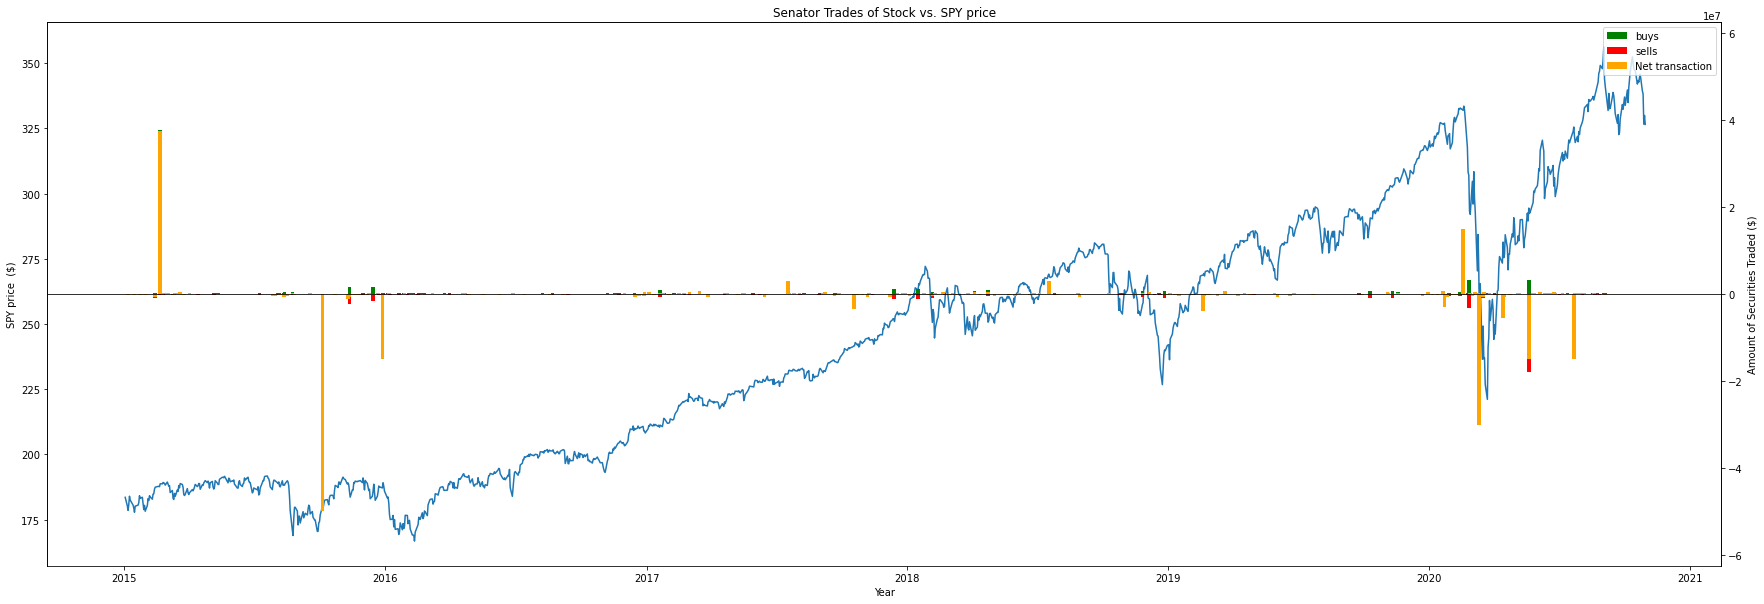

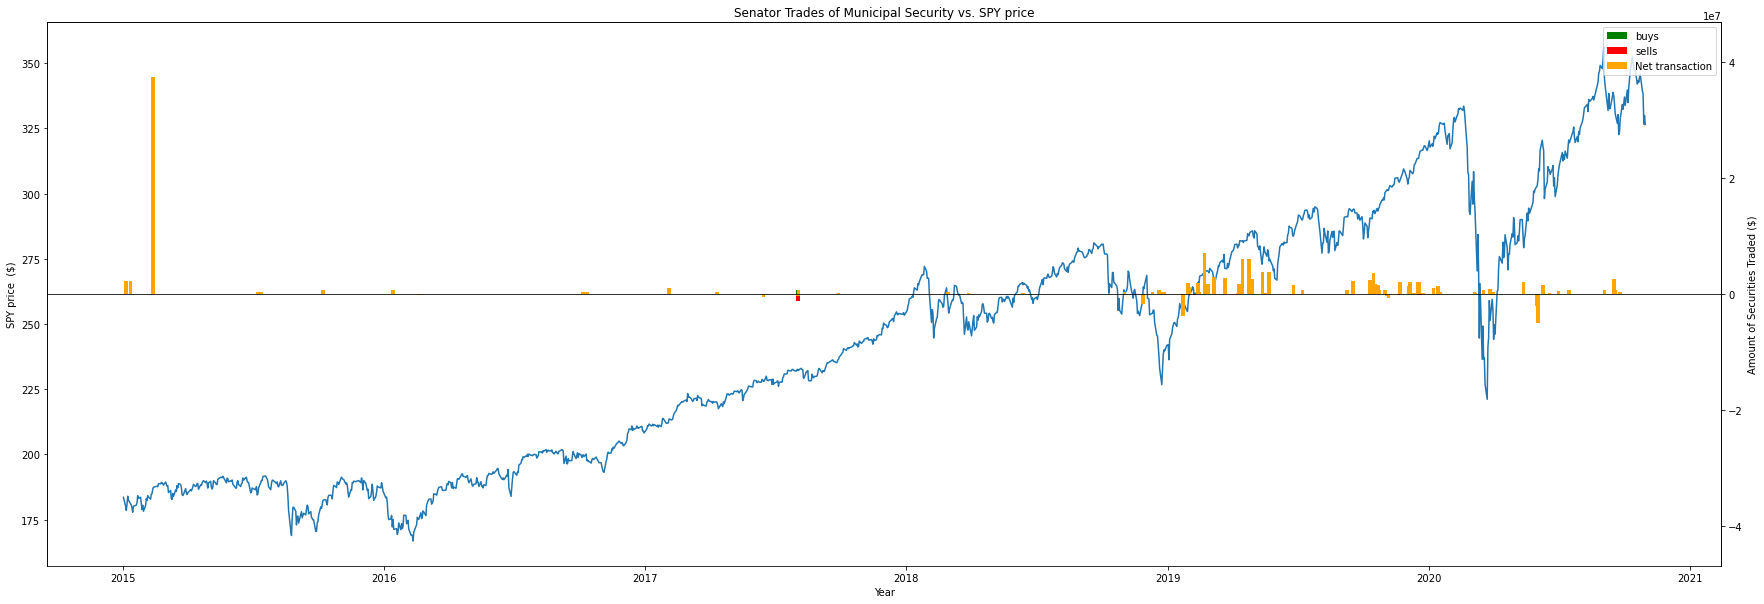

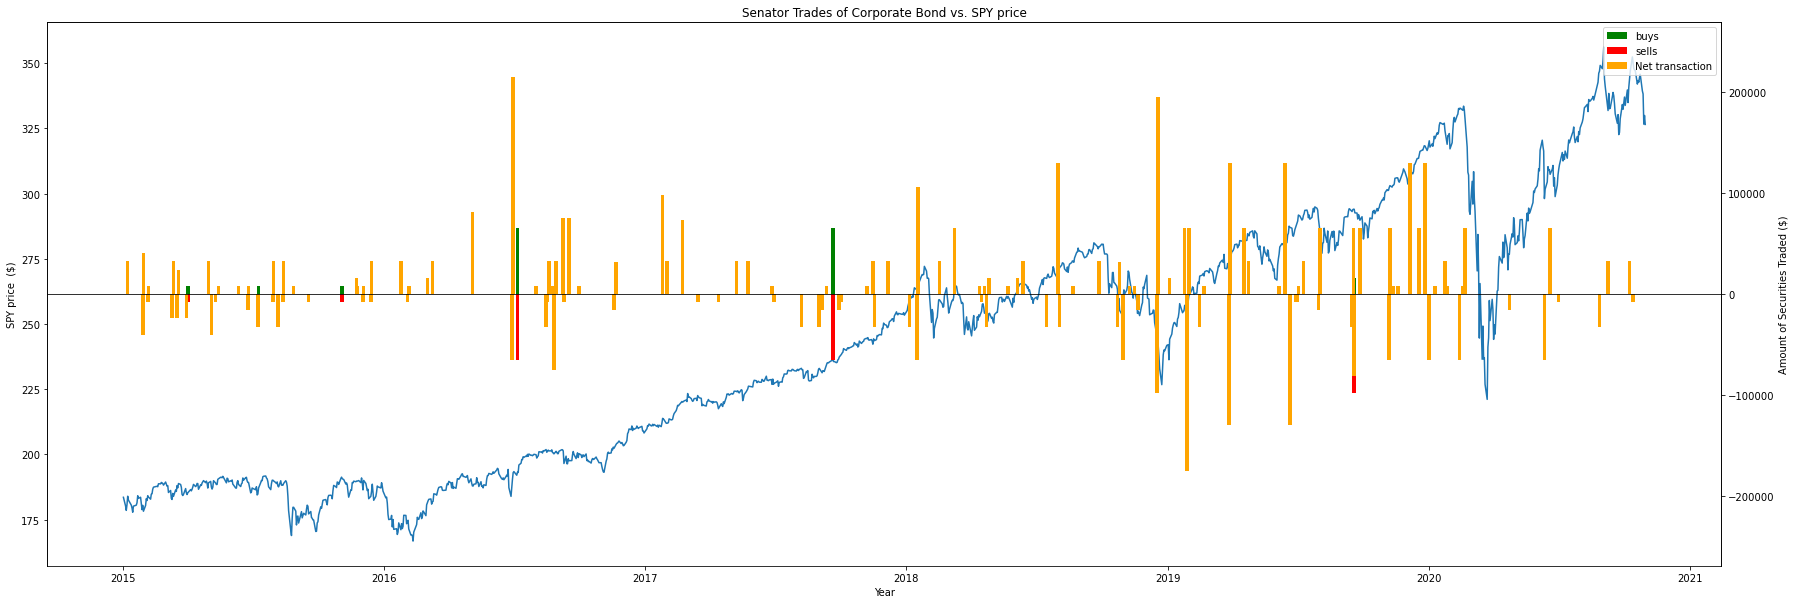

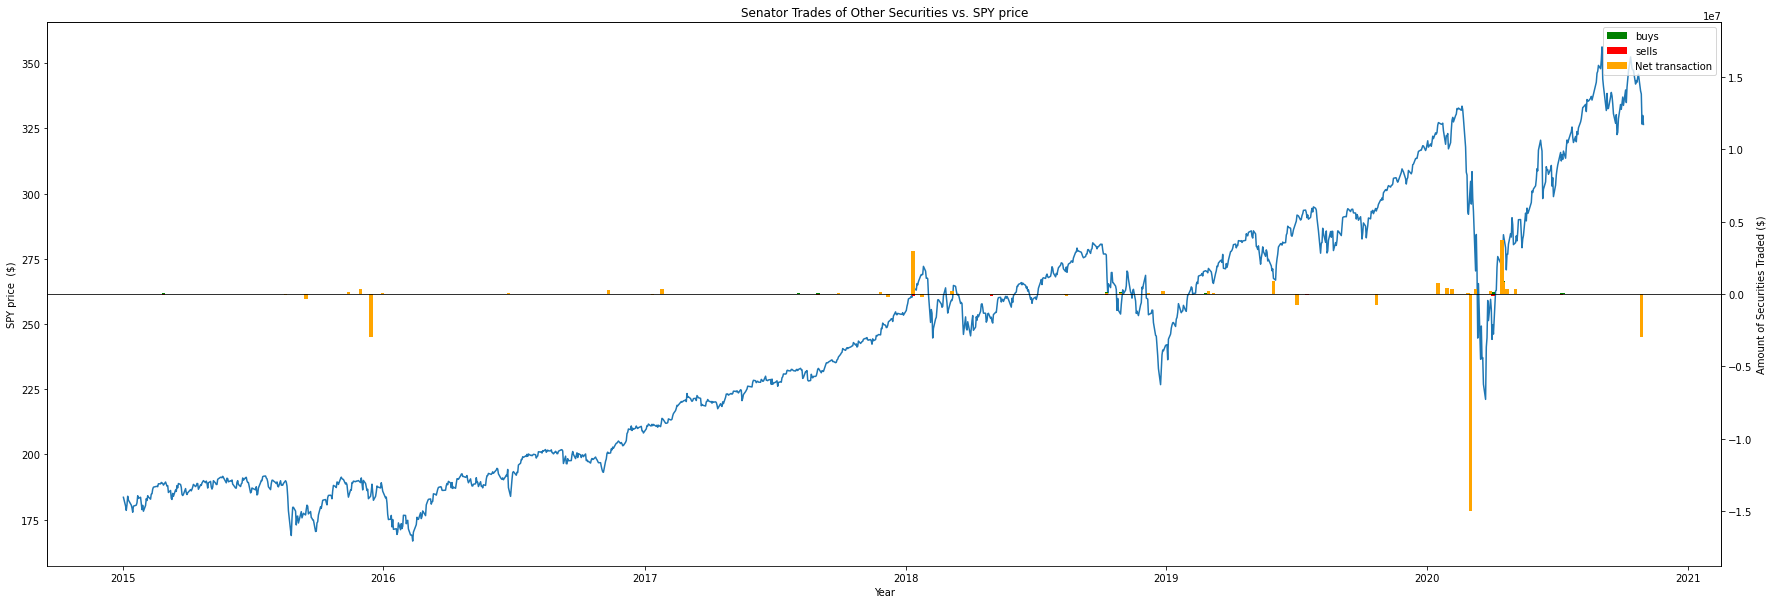

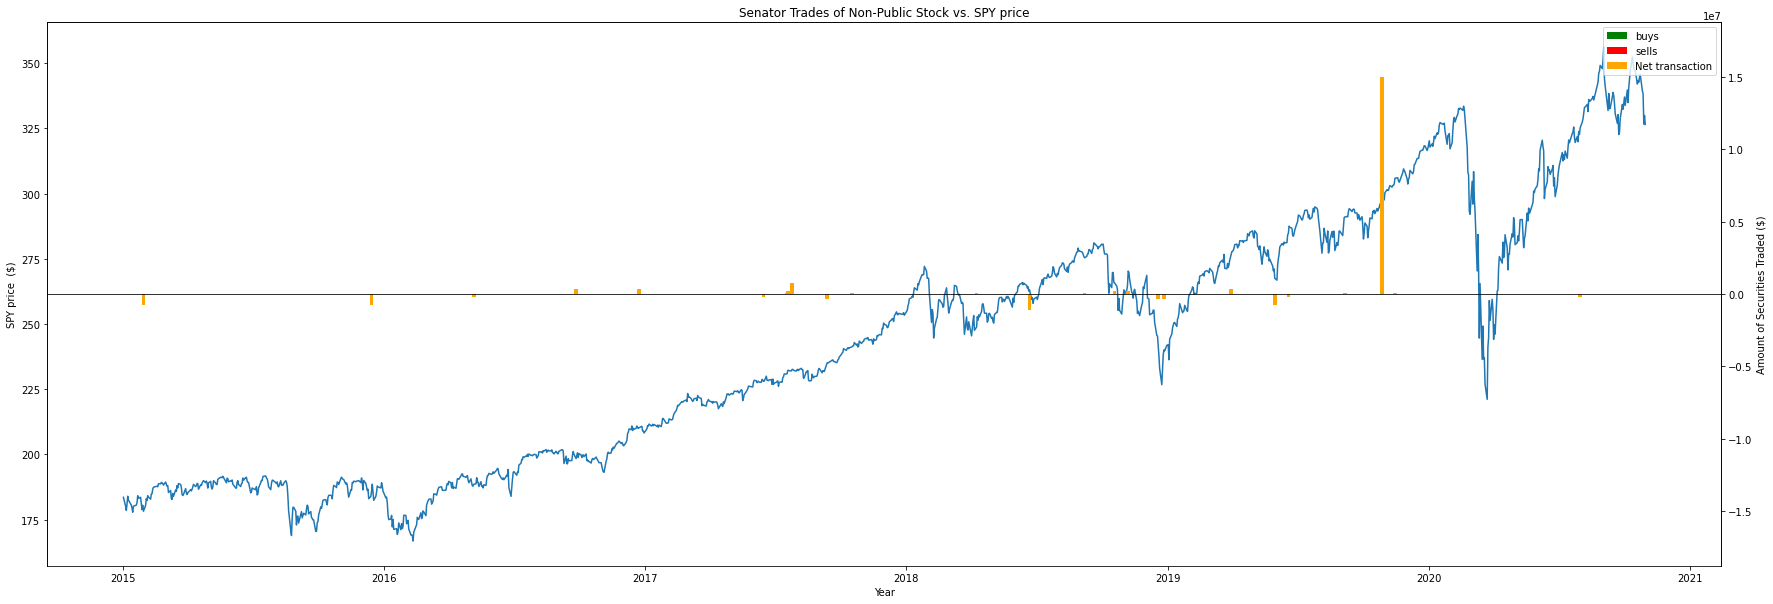

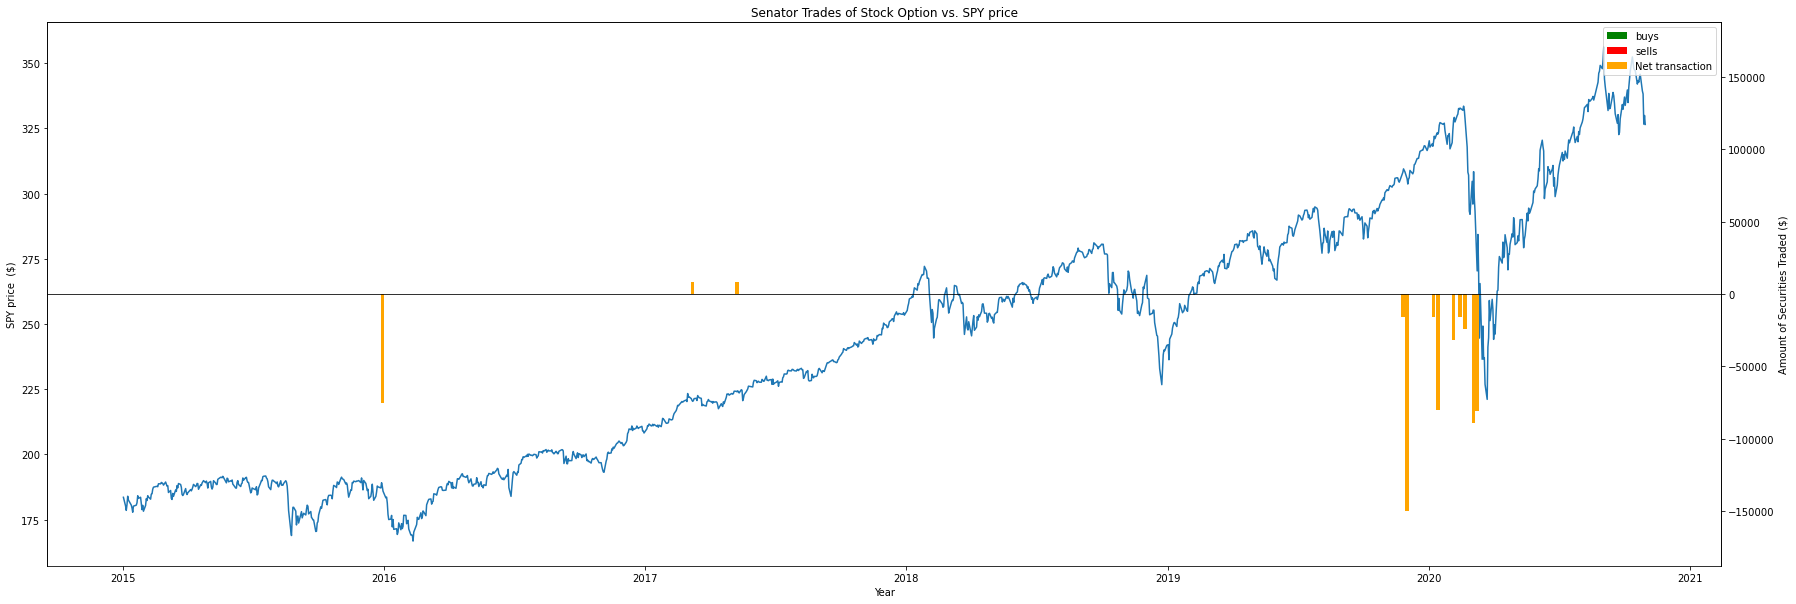

In [156]:
import matplotlib.pyplot as plt

for asset_type in aggregate_action['asset_type'].unique():

    buys = aggregate_buys[aggregate_buys['asset_type'] == asset_type]
    sells = aggregate_sells[aggregate_sells['asset_type'] == asset_type]
    total = aggregate_total[aggregate_total['asset_type'] == asset_type]

    buys = buys[(buys['transaction_date'] > start_date) & (buys['transaction_date'] < end_date)]
    sells = sells[(sells['transaction_date'] > start_date) & (sells['transaction_date'] < end_date)]
    total = total[(total['transaction_date'] > start_date) & (total['transaction_date'] < end_date)]

    # We have a lot of data, so we should make the figure very large
    plt.figure(figsize=(30,10))

    spy_hist['Date'] = spy_hist.index
    market = spy_hist[(spy_hist['Date'] > start_date) & (spy_hist['Date'] < end_date)]
    plt.plot(market['Date'], market['Close'])

    plt.xlabel('Year')
    plt.ylabel('SPY price  ($)')
    ax2 = plt.twinx()

    # scale bar graph limits s.t. 0 is centered in graph
    limit = max(abs(sells['mid_amt'].min()), buys['mid_amt'].max()) * 1.25
    ax2.set_ylim(-limit, limit)
    ax2.spines['bottom'].set_position(('data', 0))

    plt.ylabel('Amount of Securities Traded ($)')

    plt.bar(buys['transaction_date'], buys['mid_amt'], width=5, label='buys', color='green')
    plt.bar(sells['transaction_date'], sells['mid_amt'], width=5, label='sells', color='red')
    plt.bar(total['transaction_date'], total['mid_amt'], width=5, label='Net transaction', color='orange')
   
    plt.title('Senator Trades of ' + str(asset_type) + ' vs. SPY price')
    plt.legend()

    plt.show()

Let's also plot the net amount traded vs. future SPY price as well. We first need

In [227]:
import pandas_market_calendars as mcal
from datetime import datetime

nyse = mcal.get_calendar('NYSE')
market_open_days = nyse.valid_days(start_date=start_date, end_date=datetime.today().strftime('%Y-%m-%d'))

# returns a function that gets the spy price num_days from today
def get_future_spy_price(num_days):
    def h(today):
        # calculate current spy data
        today_index = market_open_days.get_loc(today, method='nearest')
        today_close = spy_hist.iloc[spy_hist.index.get_loc(today, method='nearest')]['Close']

        # calculate future date and get spy data
        future_index = today_index + num_days
        future_date = market_open_days[future_index]
        future_close = spy_hist.iloc[spy_hist.index.get_loc(future_date, method='nearest')]['Close']
        return (future_close - today_close) / today_close
    return h

aggregate_total['5_day_spy_pct_change'] = aggregate_total['transaction_date'].apply(get_future_spy_price(5))
aggregate_total['15_day_spy_pct_change'] = aggregate_total['transaction_date'].apply(get_future_spy_price(15))
aggregate_total['30_day_spy_pct_change'] = aggregate_total['transaction_date'].apply(get_future_spy_price(30))

Stock
  transaction_date          asset_type    type_x  lower_amt_x  mid_amt_x  \
0       2015-01-02               Stock  Purchase       2002.0    16001.0   
1       2015-01-05               Stock  Purchase      30002.0    65001.0   
2       2015-01-06  Municipal Security  Purchase    1500003.0  2250001.5   
3       2015-01-07               Stock  Purchase       3003.0    24001.5   
4       2015-01-08      Corporate Bond  Purchase      15001.0    32500.5   

   upper_amt_x type_y  lower_amt_y  mid_amt_y  upper_amt_y    mid_amt  \
0      30000.0      0          0.0        0.0          0.0    16001.0   
1     100000.0   Sale      30002.0   -65001.0     100000.0        0.0   
2    3000000.0      0          0.0        0.0          0.0  2250001.5   
3      45000.0      0          0.0        0.0          0.0    24001.5   
4      50000.0      0          0.0        0.0          0.0    32500.5   

   lower_amt  upper_amt  5_day_spy_pct_change  15_day_spy_pct_change  
0     2002.0    30000.0    

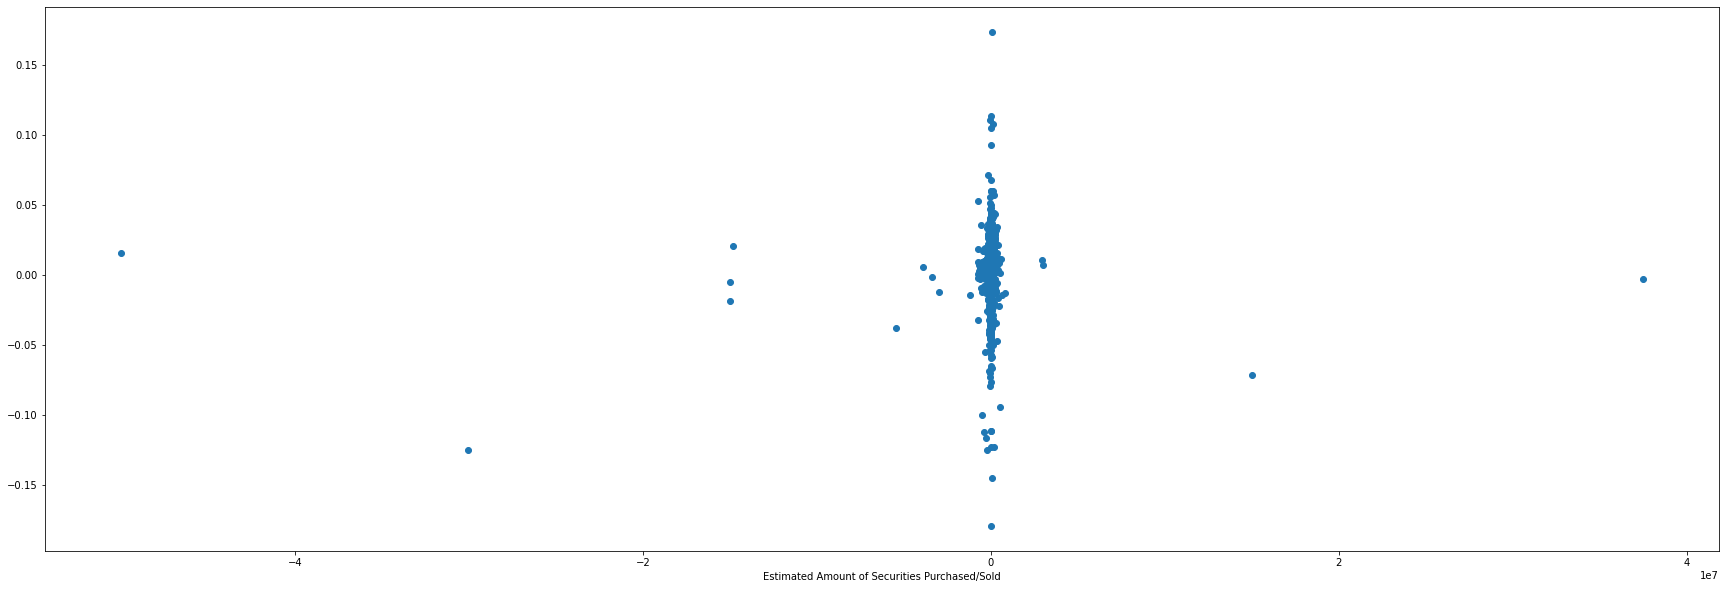

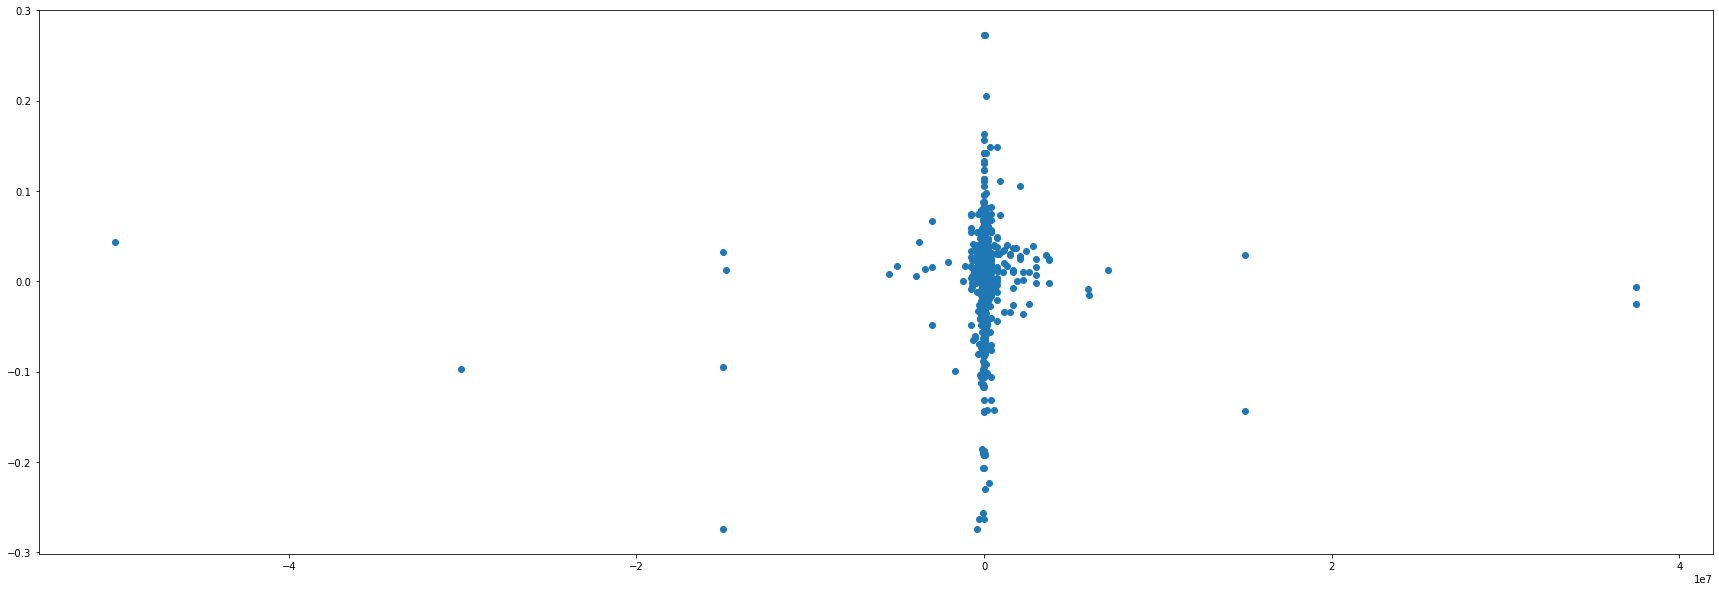

Municipal Security
  transaction_date          asset_type    type_x  lower_amt_x  mid_amt_x  \
0       2015-01-02               Stock  Purchase       2002.0    16001.0   
1       2015-01-05               Stock  Purchase      30002.0    65001.0   
2       2015-01-06  Municipal Security  Purchase    1500003.0  2250001.5   
3       2015-01-07               Stock  Purchase       3003.0    24001.5   
4       2015-01-08      Corporate Bond  Purchase      15001.0    32500.5   

   upper_amt_x type_y  lower_amt_y  mid_amt_y  upper_amt_y    mid_amt  \
0      30000.0      0          0.0        0.0          0.0    16001.0   
1     100000.0   Sale      30002.0   -65001.0     100000.0        0.0   
2    3000000.0      0          0.0        0.0          0.0  2250001.5   
3      45000.0      0          0.0        0.0          0.0    24001.5   
4      50000.0      0          0.0        0.0          0.0    32500.5   

   lower_amt  upper_amt  5_day_spy_pct_change  15_day_spy_pct_change  
0     2002.0  

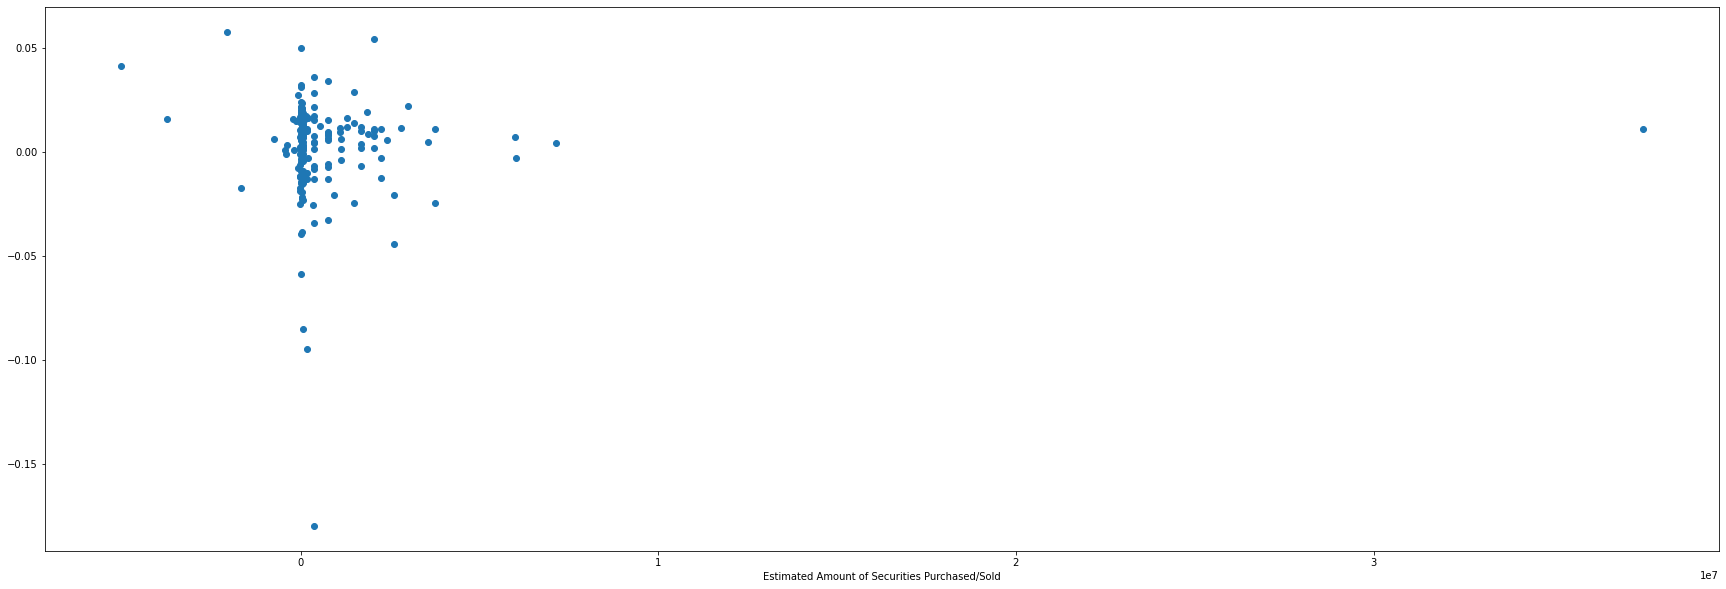

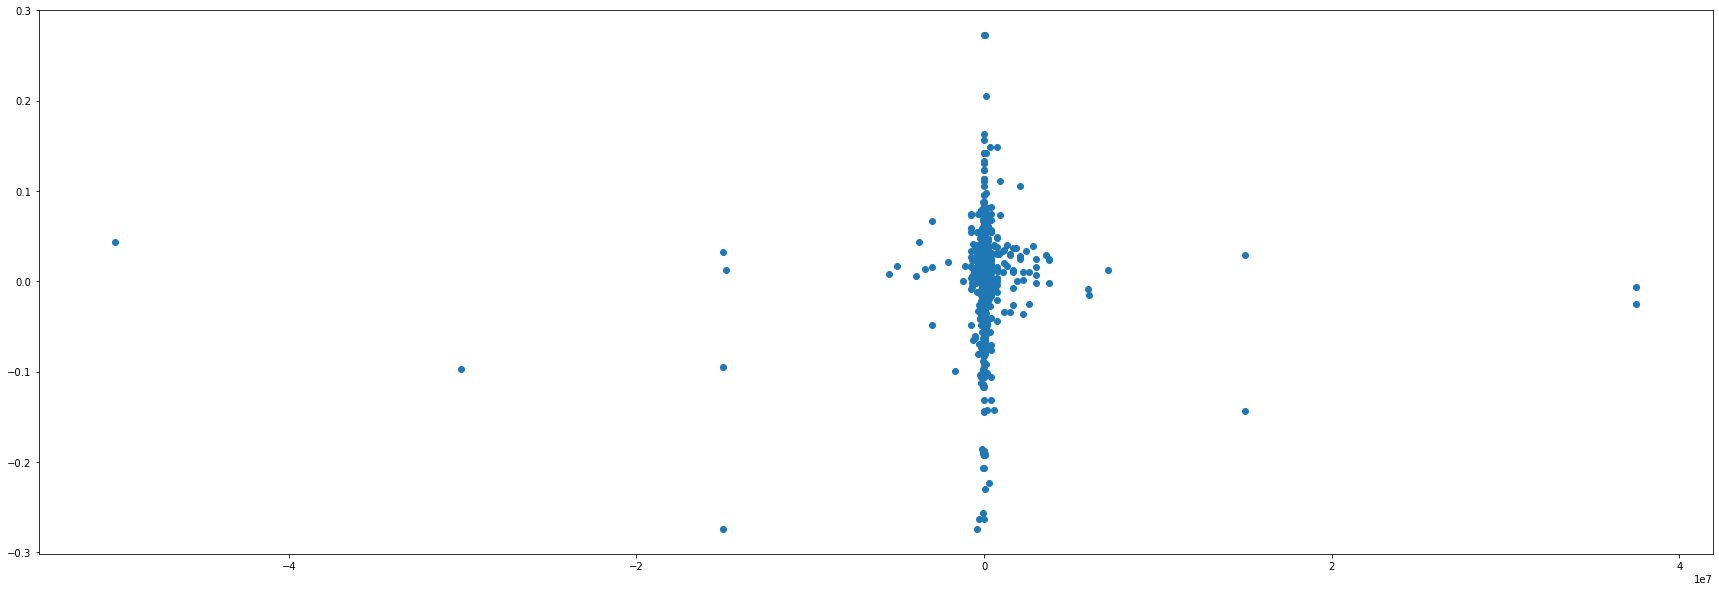

Corporate Bond
  transaction_date          asset_type    type_x  lower_amt_x  mid_amt_x  \
0       2015-01-02               Stock  Purchase       2002.0    16001.0   
1       2015-01-05               Stock  Purchase      30002.0    65001.0   
2       2015-01-06  Municipal Security  Purchase    1500003.0  2250001.5   
3       2015-01-07               Stock  Purchase       3003.0    24001.5   
4       2015-01-08      Corporate Bond  Purchase      15001.0    32500.5   

   upper_amt_x type_y  lower_amt_y  mid_amt_y  upper_amt_y    mid_amt  \
0      30000.0      0          0.0        0.0          0.0    16001.0   
1     100000.0   Sale      30002.0   -65001.0     100000.0        0.0   
2    3000000.0      0          0.0        0.0          0.0  2250001.5   
3      45000.0      0          0.0        0.0          0.0    24001.5   
4      50000.0      0          0.0        0.0          0.0    32500.5   

   lower_amt  upper_amt  5_day_spy_pct_change  15_day_spy_pct_change  
0     2002.0    30

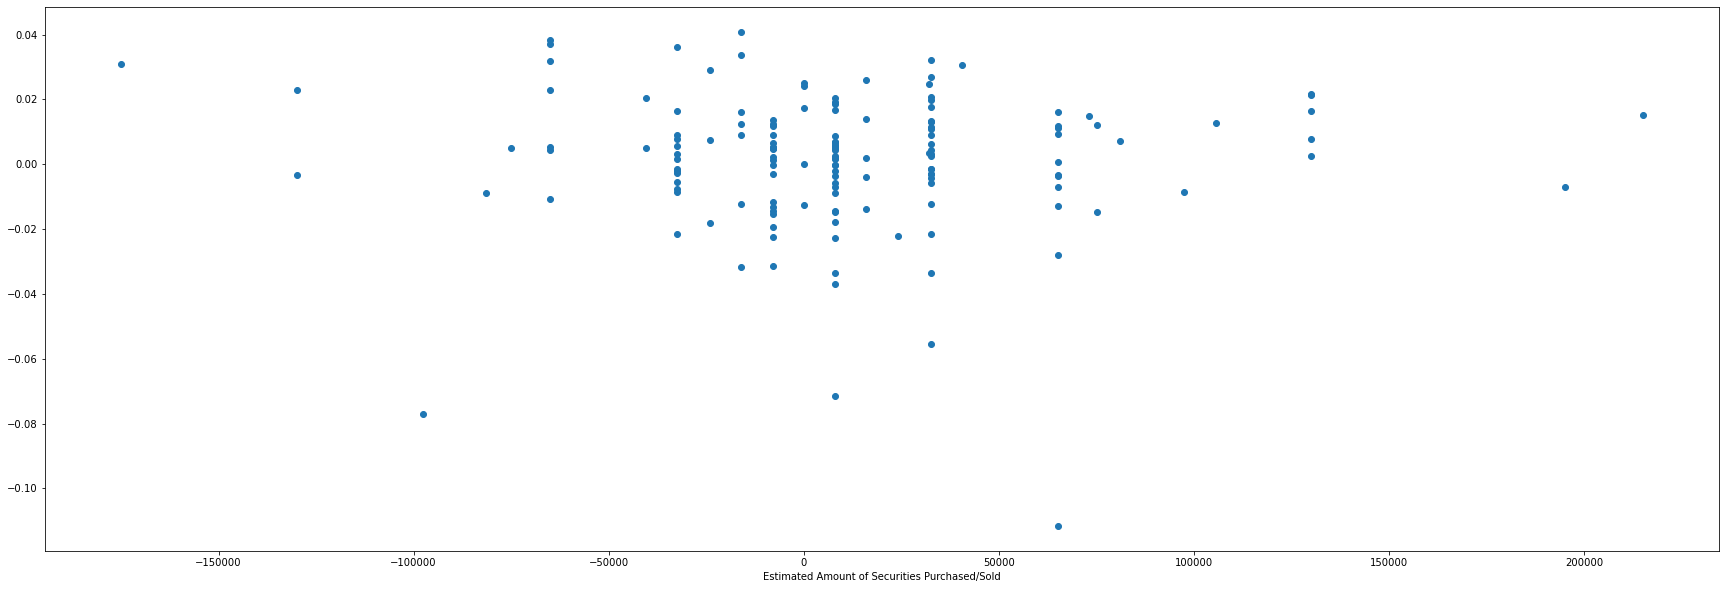

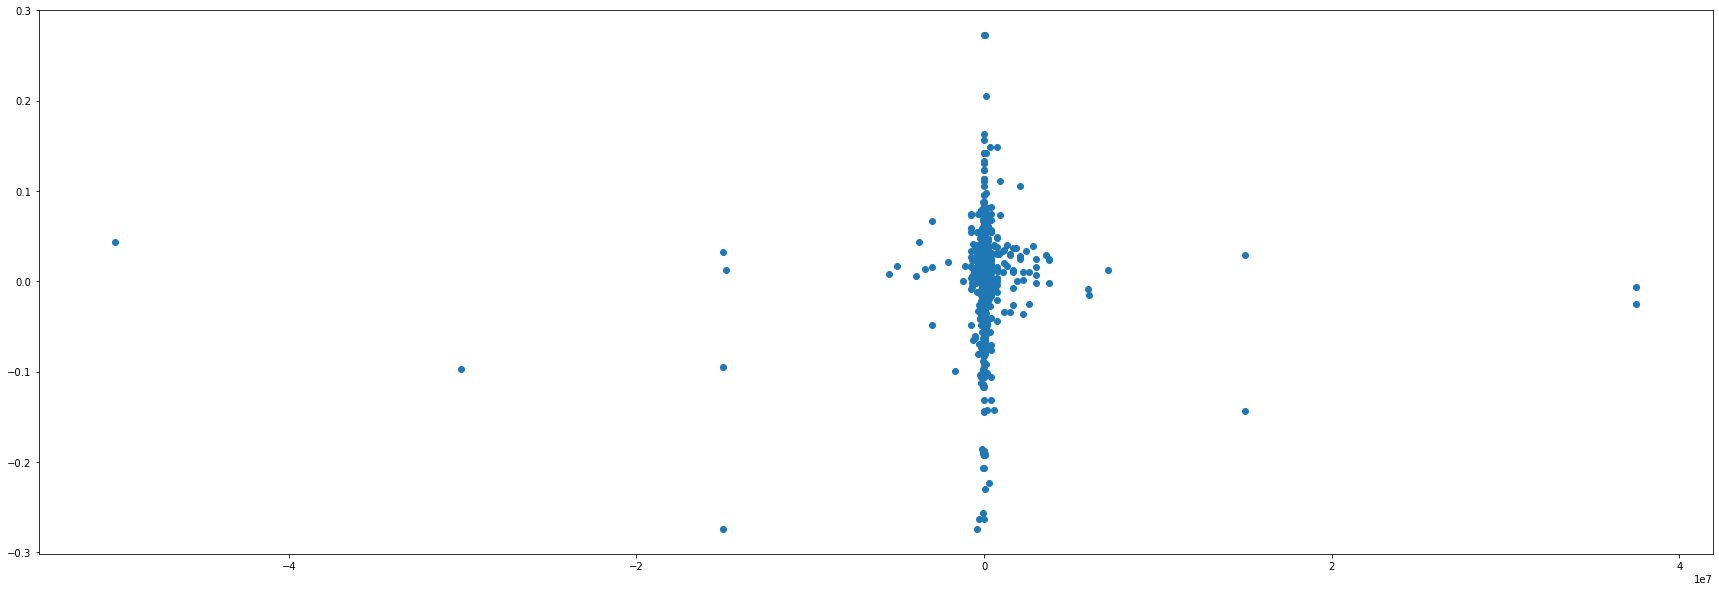

Other Securities
  transaction_date          asset_type    type_x  lower_amt_x  mid_amt_x  \
0       2015-01-02               Stock  Purchase       2002.0    16001.0   
1       2015-01-05               Stock  Purchase      30002.0    65001.0   
2       2015-01-06  Municipal Security  Purchase    1500003.0  2250001.5   
3       2015-01-07               Stock  Purchase       3003.0    24001.5   
4       2015-01-08      Corporate Bond  Purchase      15001.0    32500.5   

   upper_amt_x type_y  lower_amt_y  mid_amt_y  upper_amt_y    mid_amt  \
0      30000.0      0          0.0        0.0          0.0    16001.0   
1     100000.0   Sale      30002.0   -65001.0     100000.0        0.0   
2    3000000.0      0          0.0        0.0          0.0  2250001.5   
3      45000.0      0          0.0        0.0          0.0    24001.5   
4      50000.0      0          0.0        0.0          0.0    32500.5   

   lower_amt  upper_amt  5_day_spy_pct_change  15_day_spy_pct_change  
0     2002.0    

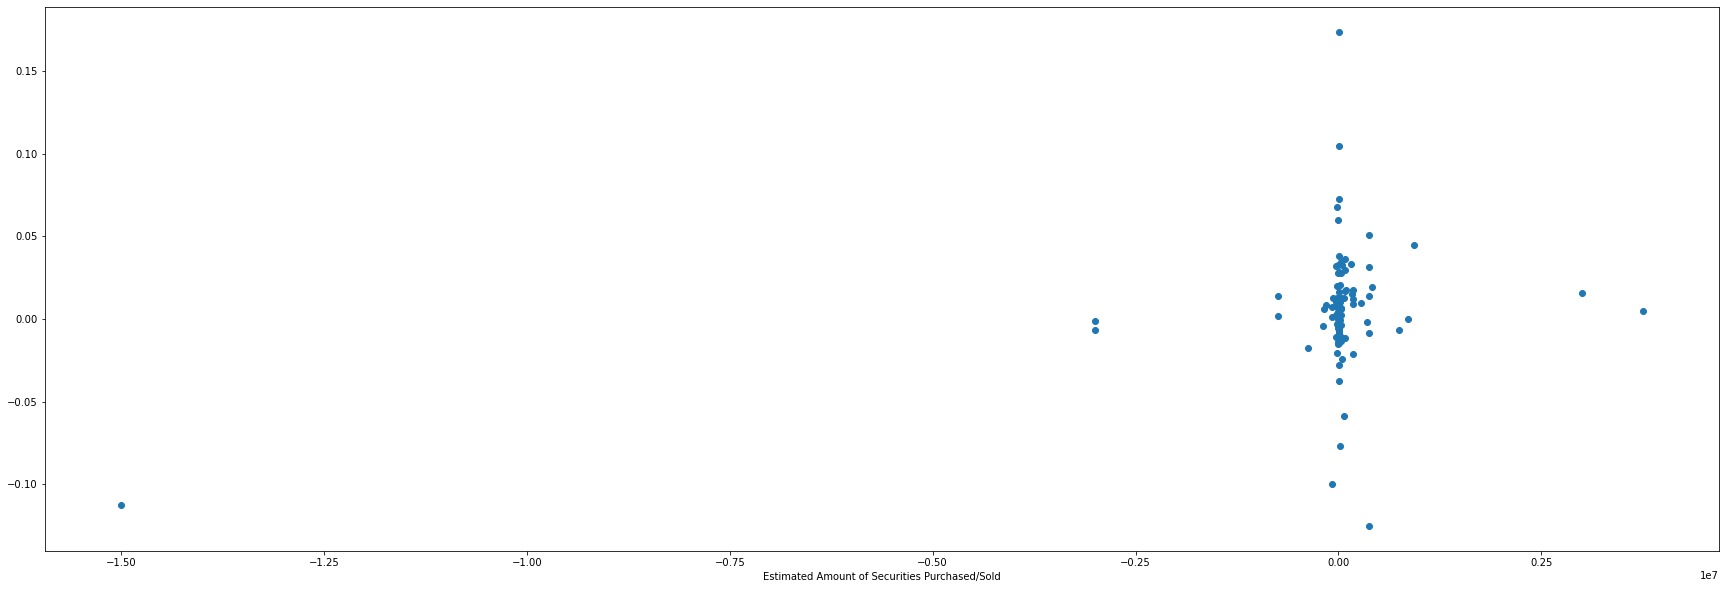

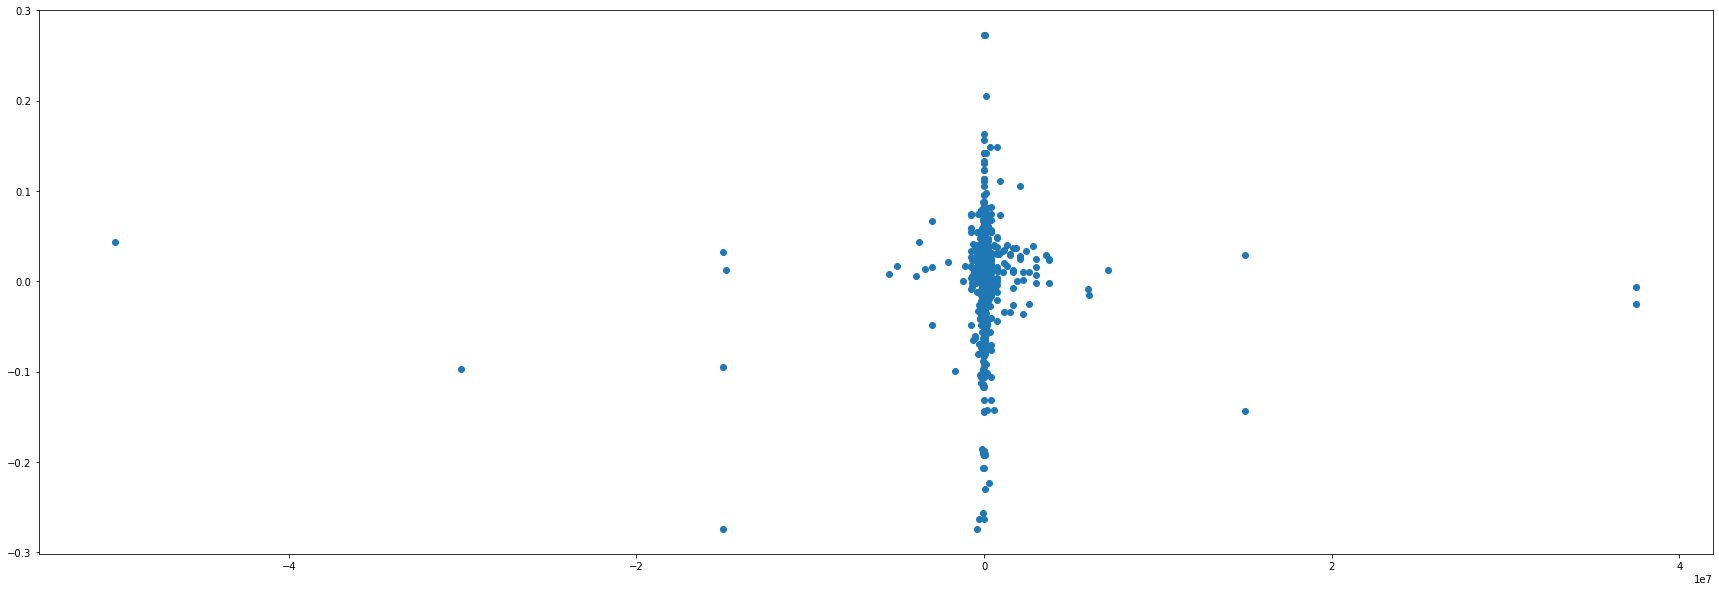

Non-Public Stock
  transaction_date          asset_type    type_x  lower_amt_x  mid_amt_x  \
0       2015-01-02               Stock  Purchase       2002.0    16001.0   
1       2015-01-05               Stock  Purchase      30002.0    65001.0   
2       2015-01-06  Municipal Security  Purchase    1500003.0  2250001.5   
3       2015-01-07               Stock  Purchase       3003.0    24001.5   
4       2015-01-08      Corporate Bond  Purchase      15001.0    32500.5   

   upper_amt_x type_y  lower_amt_y  mid_amt_y  upper_amt_y    mid_amt  \
0      30000.0      0          0.0        0.0          0.0    16001.0   
1     100000.0   Sale      30002.0   -65001.0     100000.0        0.0   
2    3000000.0      0          0.0        0.0          0.0  2250001.5   
3      45000.0      0          0.0        0.0          0.0    24001.5   
4      50000.0      0          0.0        0.0          0.0    32500.5   

   lower_amt  upper_amt  5_day_spy_pct_change  15_day_spy_pct_change  
0     2002.0    

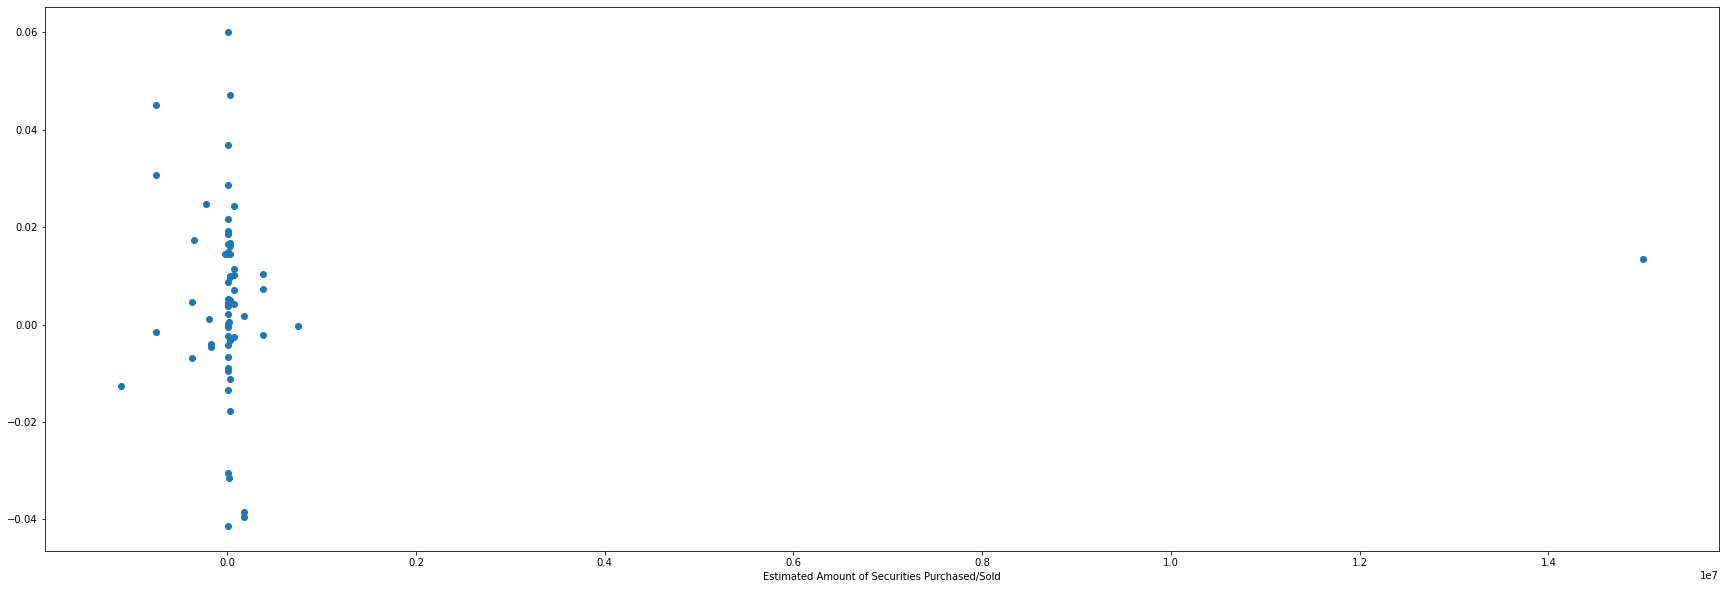

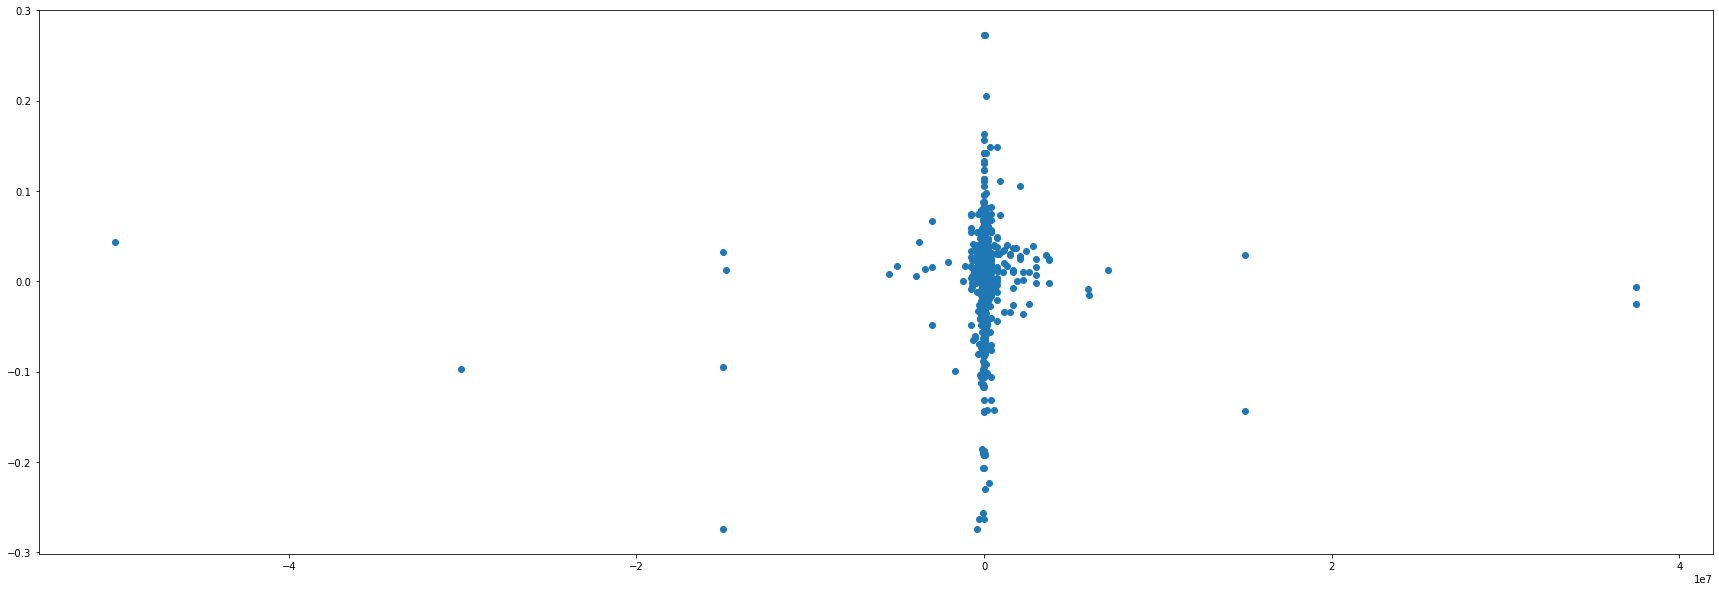

Stock Option
  transaction_date          asset_type    type_x  lower_amt_x  mid_amt_x  \
0       2015-01-02               Stock  Purchase       2002.0    16001.0   
1       2015-01-05               Stock  Purchase      30002.0    65001.0   
2       2015-01-06  Municipal Security  Purchase    1500003.0  2250001.5   
3       2015-01-07               Stock  Purchase       3003.0    24001.5   
4       2015-01-08      Corporate Bond  Purchase      15001.0    32500.5   

   upper_amt_x type_y  lower_amt_y  mid_amt_y  upper_amt_y    mid_amt  \
0      30000.0      0          0.0        0.0          0.0    16001.0   
1     100000.0   Sale      30002.0   -65001.0     100000.0        0.0   
2    3000000.0      0          0.0        0.0          0.0  2250001.5   
3      45000.0      0          0.0        0.0          0.0    24001.5   
4      50000.0      0          0.0        0.0          0.0    32500.5   

   lower_amt  upper_amt  5_day_spy_pct_change  15_day_spy_pct_change  
0     2002.0    3000

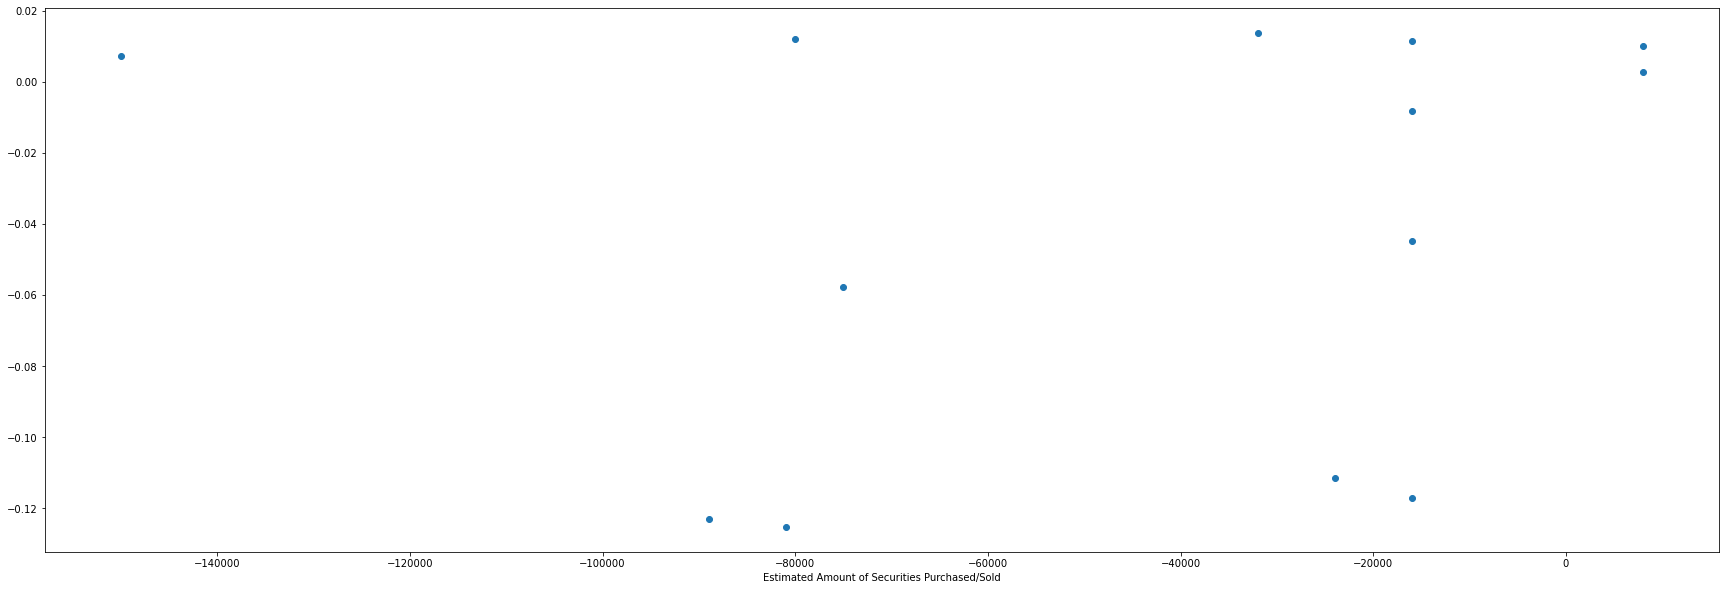

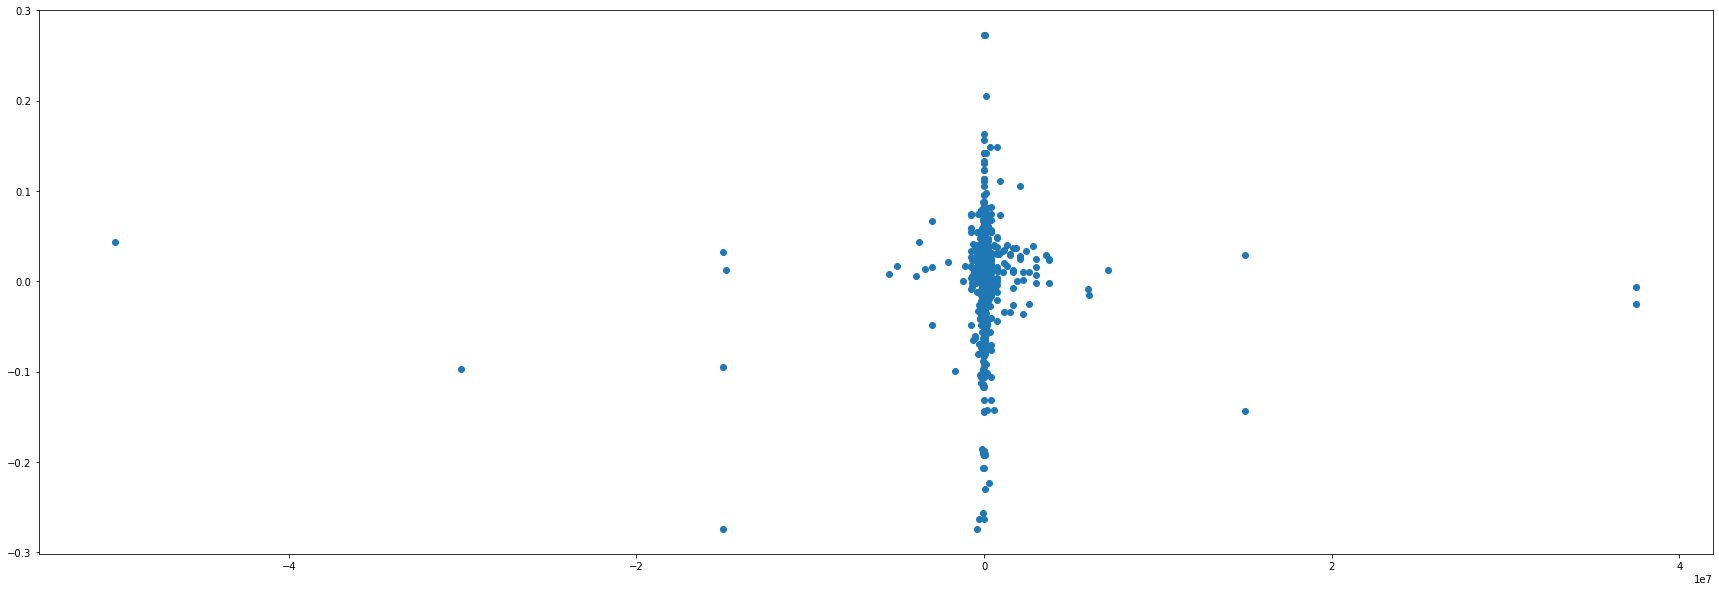

In [257]:
test = aggregate_total[abs(aggregate_total['lower_amt']) > 0]

for asset_type in test['asset_type'].unique():
    print(asset_type)
    testx = test[test['asset_type'] == asset_type]
    print(test.head())
    plt.figure(figsize=(30,10))
    plt.scatter(testx['mid_amt'], testx['5_day_spy_pct_change'])
    plt.xlabel('Estimated Amount of Securities Purchased/Sold')
    plt.show()

    plt.figure(figsize=(30,10))
    plt.scatter(test['mid_amt'], test['15_day_spy_pct_change'])
    plt.show()

    plt.figure(figsize=(30,10))
    plt.scatter(test['mid_amt'], test['30_day_spy_pct_change'])
    plt.show()